In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [27]:
import requests
import json
url = "https://raw.githubusercontent.com/duhaime/umap-zoo/03819ed0954b524919671a72f61a56032099ba11/data/json/bison.json"
animal = np.array(json.loads(requests.get(url).text)['3d'])
np.shape(animal)

(50000, 3)

In [28]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [29]:
animal = norm(animal)

In [30]:
np.min(animal, axis=0)

array([0.3590171 , 0.28384773, 0.        ])

(-0.051642771804062126,
 1.0516427718040622,
 0.25322656186139164,
 0.8763034951339842)

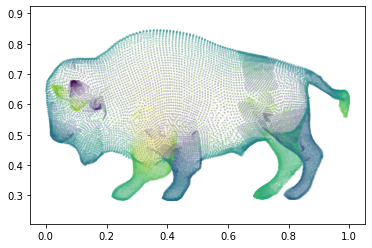

In [31]:
fig, ax = plt.subplots()
ax.scatter(animal[:,2], animal[:,1], s = 1, c = animal[:,0], alpha = 0.1)
ax.axis('equal')

In [32]:
X_train = animal
Y_train = animal[:, 2]
X_train_flat = X_train

### define networks

In [33]:
dims = 3
n_components = 2

In [34]:
from tfumap.vae import VAE, Sampling

In [35]:
encoder_inputs = tf.keras.Input(shape=dims)
x = tf.keras.layers.Flatten()(encoder_inputs)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
z_mean = tf.keras.layers.Dense(n_components, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(n_components, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3)            0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 100)          400         flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 100)          10100       dense_11[0][0]                   
____________________________________________________________________________________________

In [36]:
latent_inputs = tf.keras.Input(shape=(n_components,))
x = tf.keras.layers.Dense(units=100, activation="relu")(latent_inputs)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
decoder_outputs = tf.keras.layers.Dense(units=dims, activation="sigmoid")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 303       
Total params: 20,803
Trainable params: 20,803
Non-trainable params: 0
_________________________________________________________________


### Create model and train

In [37]:
X_train.shape

(50000, 3)

In [38]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [39]:
vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 1s 3ms/step - loss: 500.6373 - reconstruction_loss: 499.0743 - kl_loss: 1.5631
Epoch 2/30
391/391 [==============================] - 1s 3ms/step - loss: 489.2774 - reconstruction_loss: 486.9273 - kl_loss: 2.3501
Epoch 3/30
391/391 [==============================] - 1s 3ms/step - loss: 488.8535 - reconstruction_loss: 486.5250 - kl_loss: 2.3284
Epoch 4/30
391/391 [==============================] - 1s 3ms/step - loss: 488.7324 - reconstruction_loss: 486.4098 - kl_loss: 2.3226
Epoch 5/30
391/391 [==============================] - 1s 3ms/step - loss: 488.6591 - reconstruction_loss: 486.3396 - kl_loss: 2.3195
Epoch 6/30
391/391 [==============================] - 1s 3ms/step - loss: 488.6270 - reconstruction_loss: 486.3161 - kl_loss: 2.3109
Epoch 7/30
391/391 [==============================] - 1s 3ms/step - loss: 488.6031 - reconstruction_loss: 486.2964 - kl_loss: 2.3067
Epoch 8/30
391/391 [==============================] - 1s 3ms/step - l

In [40]:
z = vae.encoder.predict(X_train)[0]

### Plot model output

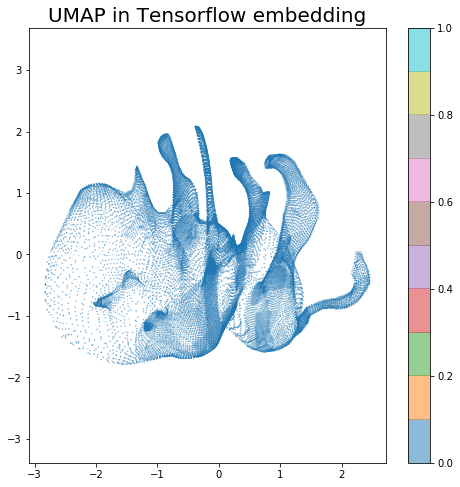

In [42]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)].flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [43]:
z_recon = decoder.predict(z)

(-0.04467518459382415,
 1.0391183068913494,
 0.2614682405814254,
 0.8444376498833573)

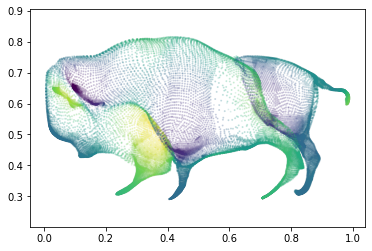

In [44]:
fig, ax = plt.subplots()
ax.scatter(z_recon[:,2], z_recon[:,1], s = 1, c = z_recon[:,0], alpha = 0.1)
ax.axis('equal')

### Save output

In [45]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [46]:
dataset = 'bison'

In [47]:
output_dir = MODEL_DIR/'projections'/ dataset / 'vae'
ensure_dir(output_dir)

In [48]:
encoder.save(output_dir / 'encoder')

W0822 11:25:33.269152 140530040182592 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
W0822 11:25:33.279781 140530040182592 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
I0822 11:25:33.634426 140530040182592 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/bison/vae/enc

In [49]:
decoder.save(output_dir / 'encoder')

I0822 11:25:33.984817 140530040182592 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/bison/vae/encoder/assets


In [50]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [51]:
np.save(output_dir / 'z.npy', z)